# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [13]:
# import libraries
import pandas as pd

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sqlalchemy import create_engine
import re

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV


import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
original_df = pd.read_sql('SELECT * FROM messages', engine)

original_df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Prepare data
df = original_df.copy()

df['related'] = df['related'].map(lambda x: 1 if x == 2 else x)

df.drop('child_alone', axis=1, inplace=True)
df.drop('id',axis=1, inplace=True)

X = df['message']
y = df.iloc[:, 4:]

print(X.shape)
print(y.shape)

(26216,)
(26216, 34)


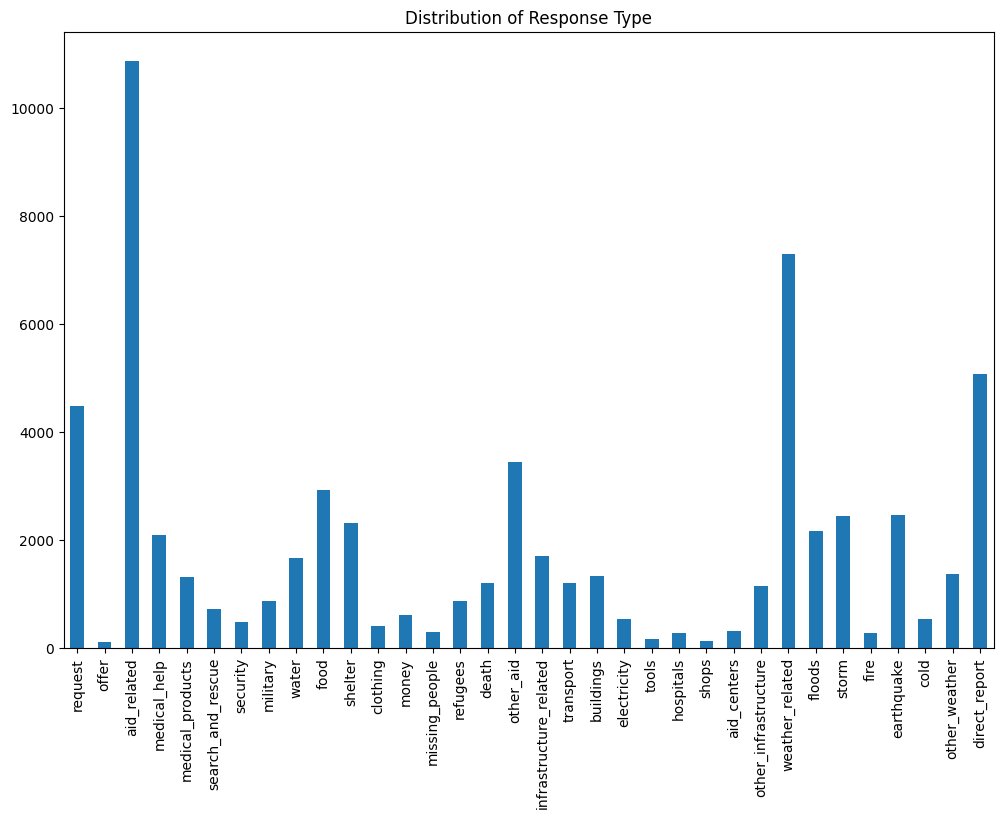

In [7]:
plt.figure(figsize=(12,8))
y.sum().plot(kind='bar')
plt.title("Distribution of Response Type")
plt.savefig("Distribution of Response Type.png",dpi=300)

### 2. Write a tokenization function to process your text data

In [8]:
def tokenize(text):
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # Tokenize text
    words = word_tokenize(text)

    # Remove Stop words
    words = [w for w in words if w not in stopwords.words("english")]

    # Reduce words to their stems
    words = [WordNetLemmatizer().lemmatize(w) for w in words]

    return words

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [9]:
pipeline = Pipeline([
    # ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfVectorizer(tokenizer=tokenize,use_idf=True, smooth_idf=True, sublinear_tf=False)),
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42,n_jobs=-1), n_jobs=-1))
    ]
)



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)

pipeline.fit(X_train, y_train)

(18351,)
(18351, 34)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7a86c0d593f0>)),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                                        random_state=42),
                                       n_jobs=-1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
# predict on test data
y_pred = pipeline.predict(X_test)


In [15]:
# Print calculations
def get_metrics(y_test, y_pred):
    """
    get_metrices calculate f1 score, accuracy and recall

    Args:
      y_test: list of actual values
      y_pred: list of predicted values

    Returns:
      Dictionary of accuracy, precision, recall and f1 score
    """
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    f1_scoree = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_scoree}




{'Accuracy': 0.410680228862047, 'Precision': 0.7991820921222557, 'Recall': 0.3948529802733025, 'F1 Score': 0.528559735221894}


### 6. Improve your model
Use grid search to find better parameters.

In [25]:
param_grid = {

    'clf__estimator__n_estimators': [10, 20, 30, 40, 50],  # Number of trees in the random forest
    # 'clf__estimator__max_depth': [None, 10, 20],     # Max depth of each tree
    # 'clf__estimator__min_samples_split': [2, 5, 10]  # Minimum samples required to split a node
}

# Initialize GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=2)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2, scoring='f1_weighted', verbose=2)

# Run grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=10; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=10; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=20; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=20; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=30; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=30; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=40; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=40; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=50; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ....................clf__estimator__n_estimators=50; total time= 2.8min


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best Parameters: {'clf__estimator__n_estimators': 50}
Best F1 Score: 0.45111082694891524


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [27]:
print(get_metrics(y_test, y_pred))

{'Accuracy': 0.410680228862047, 'Precision': 0.7991820921222557, 'Recall': 0.3948529802733025, 'F1 Score': 0.528559735221894}


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [28]:
# prompt: export model to a pkl file

import pickle

# Assuming 'grid_search.best_estimator_' is your trained model
model_filepath = 'classifier.pkl'
pickle.dump(grid_search.best_estimator_, open(model_filepath, 'wb'))

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.